Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 543629.7500 - val_loss: 307972.9062
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 543609.6250 - val_loss: 307969.3125
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 543598.7500 - val_loss: 307968.1875
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 543598.0000 - val_loss: 307968.1250
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 543597.8750 - val_loss: 307968.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 543597.7500 - val_loss: 307967.9375
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 543597.3125 - val_loss: 307962.4688
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 543593.8750 - val_loss: 307961.1250
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 543590.6875 - val_loss: 307950.7500
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 543582.3750 - val_loss: 307834.3125
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 543

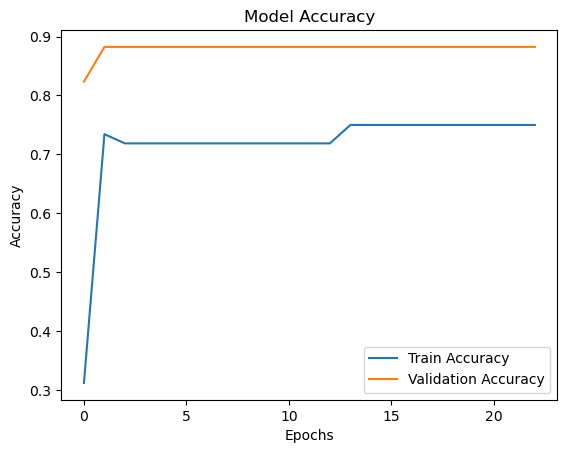

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Step 1: Load the CSV data
data = pd.read_csv("data.csv")  # Replace 'data.csv' with your file name

# Step 2: Preprocess the data
X = data.drop(columns=["Class", "UID", "Trial", "TrialSeq"])  # Exclude non-feature columns
y = data["Class"]

# Encode the target label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 3: Feature Extraction Using Autoencoder

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the Autoencoder structure for feature extraction
input_dim = X.shape[1]  # Number of features in the dataset

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)  # Encoding layer
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)  # Bottleneck layer (compressed representation)
decoded = Dense(64, activation='relu')(encoded)  # Decoding layer
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)  # Output layer for reconstruction

# Compile the Autoencoder model
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder for feature extraction
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Extract the encoder part (for feature extraction)
encoder = Model(input_layer, encoded)

# Transform the data using the trained encoder
X_encoded = encoder.predict(X)

# Step 3.5: PCA (optional, after autoencoder feature extraction)
pca = PCA(n_components=12)  # Reduce to 12 features for simplicity
X_final = pca.fit_transform(X_encoded)

# Verify PCA output
print(f"PCA Output Shape: {X_final.shape}, y Shape: {len(y)}")

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Step 5: Standardize the data (for deep learning models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input to match Conv1D's expected input (adding an extra dimension)
X_train = np.expand_dims(X_train, axis=2)  # Reshape to (batch_size, num_features, 1)
X_test = np.expand_dims(X_test, axis=2)    # Reshape to (batch_size, num_features, 1)

# Step 6: Build the Deep Learning Model with CNN for Feature Learning and Dense Layers for Classification

class DeepCNNModel(tf.keras.Model):
    def __init__(self):
        super(DeepCNNModel, self).__init__()
        # CNN layers for feature extraction
        self.conv1 = layers.Conv1D(64, 3, activation='relu', padding='same')
        self.pool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, 3, activation='relu', padding='same')
        self.pool2 = layers.MaxPooling1D(pool_size=2)

        # Fully connected (Dense) layers for classification
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dropout = layers.Dropout(0.3)
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize the model
model = DeepCNNModel()

# Step 7: Compile the model with class weights
class_weights = {0: 1.0, 1: 1.5}  # Adjust class weights if needed for imbalanced classes
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model with early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping, lr_scheduler], 
                    class_weight=class_weights)

# Step 9: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Visualize training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 10: Save the model
model.save("dysgraphia_deep_learning_model_cnn.keras")


PCA Output Shape: (76, 12), y_filtered Shape: 76
Epoch 1/100


C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Lahari\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['deep_cnn_model_3/conv1d_12/kernel', 'deep_cnn_model_3/conv1d_12/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 563ms/step - accuracy: 0.7500 - loss: 0.8994 - val_accuracy: 0.7500 - val_loss: 0.5966 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7722 - loss: 0.7383 - val_accuracy: 0.7500 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7826 - loss: 0.6272 - val_accuracy: 0.7500 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7618 - loss: 0.6222 - val_accuracy: 0.7500 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7826 - loss: 0.5895 - val_accuracy: 0.7500 - val_loss: 0.7347 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7931 - loss: 0.5853 - val_accuracy: 0.7500 - val_loss: 0.7610 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8035 - loss: 0.5641 - val_accuracy: 0.750

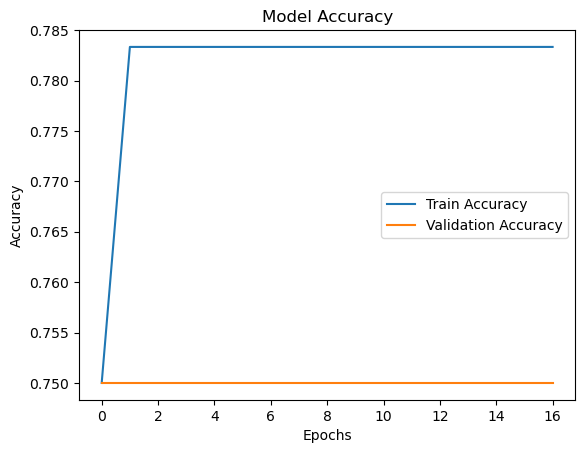

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Step 1: Load the CSV data
data = pd.read_csv("data.csv")  # Replace 'data.csv' with your file name

# Step 2: Preprocess the data
X = data.drop(columns=["Class", "UID", "Trial", "TrialSeq"])  # Exclude non-feature columns
y = data["Class"]

# Encode the target label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 3: Confidence Partitioning - Select high-correlation features with target
confidence_scores = X.corrwith(pd.Series(y)).abs()  # Correlation between features and target
confidence_threshold = 0.1  # Set a threshold to keep high-confidence features
high_confidence_features = confidence_scores[confidence_scores > confidence_threshold].index
X_confidence = X[high_confidence_features]

# Step 4: Sample Filtering - Remove outliers based on Z-scores
z_scores = np.abs(zscore(X_confidence))
X_filtered = X_confidence[(z_scores < 3).all(axis=1)]  # Remove rows where any feature has a Z-score > 3
y_filtered = y[(z_scores < 3).all(axis=1)]

# Step 5: GTST (Generalized Time Series Transformation)
# Assume GTST involves some form of transformation, such as normalization, windowing, or Fourier transform.
# For simplicity, let's use PCA for dimensionality reduction as a stand-in for GTST.

# Optionally use GTST (like windowing, Fourier transform, etc.) here. For now, using PCA:
pca = PCA(n_components=12)  # Reduce to 12 features for simplicity
X_transformed = pca.fit_transform(X_filtered)

# Verify PCA output
print(f"PCA Output Shape: {X_transformed.shape}, y_filtered Shape: {len(y_filtered)}")

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_filtered, test_size=0.2, random_state=42)

# Step 7: Standardize the data (for deep learning models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input to match Conv1D's expected input (adding an extra dimension)
X_train = np.expand_dims(X_train, axis=2)  # Reshape to (batch_size, num_features, 1)
X_test = np.expand_dims(X_test, axis=2)    # Reshape to (batch_size, num_features, 1)

# Step 8: Build the Deep Learning Model with CNN for Feature Learning and Dense Layers for Classification

class DeepCNNModel(tf.keras.Model):
    def __init__(self):
        super(DeepCNNModel, self).__init__()
        # CNN layers for feature extraction
        self.conv1 = layers.Conv1D(64, 3, activation='relu', padding='same')
        self.pool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, 3, activation='relu', padding='same')
        self.pool2 = layers.MaxPooling1D(pool_size=2)

        # Fully connected (Dense) layers for classification
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dropout = layers.Dropout(0.3)
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(inputs)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize the model
model = DeepCNNModel()

# Step 9: Compile the model with class weights
class_weights = {0: 1.0, 1: 1.5}  # Adjust class weights if needed for imbalanced classes
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Step 10: Train the model with early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping, lr_scheduler], 
                    class_weight=class_weights)

# Step 11: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Visualize training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 12: Save the model
model.save("dysgraphia_deep_learning_model_cnn_with_GTST.keras")
